In [46]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [47]:
import sys
import os
import random
import gc
import subprocess
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('./stylelib/custom.mplstyle')

## Extract a random sample 1% of the original size

In [66]:
%%time
raw_csv = './data/train.csv'
sample_csv = './data/train_sample.csv'
need_to_sample = True

if need_to_sample:
    result = subprocess.check_output('wc -l {}'.format(raw_csv), shell=True)
    nlines_total = int(result.split()[0])
    nlines_sample = int(0.01 * nlines_total)
    subprocess.call('head -1 {} > {}'.format(raw_csv, sample_csv), shell=True)
    subprocess.call('gshuf -n {} {} >> {}'.format(nlines_sample, raw_csv, sample_csv), shell=True)

CPU times: user 5.05 ms, sys: 11.3 ms, total: 16.4 ms
Wall time: 2min 11s


In [67]:
print(nlines_total, nlines_sample)

184903891 1849038


In [68]:
# Load sampled csv into pandas dataframe, sort by click time (and reset index)
df = pd.read_csv(
    sample_csv, parse_dates=['click_time', 'attributed_time']
).sort_values(by='click_time').reset_index()

In [69]:
df.head()

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,1723384,89489,3,1,13,379,2017-11-06 15:13:23,NaT,0
1,425613,85896,3,1,13,379,2017-11-06 15:48:37,NaT,0
2,1708684,142814,3,1,13,379,2017-11-06 15:52:55,NaT,0
3,1488287,103463,14,1,19,478,2017-11-06 15:54:19,NaT,0
4,1382146,119934,12,1,20,245,2017-11-06 16:00:01,NaT,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849038 entries, 0 to 1849037
Data columns (total 9 columns):
index              int64
ip                 int64
app                int64
device             int64
os                 int64
channel            int64
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed      int64
dtypes: datetime64[ns](2), int64(7)
memory usage: 127.0 MB


In [71]:
for col in ['click_time', 'attributed_time']:
    df[col] = pd.DatetimeIndex(df[col]).tz_localize('utc').tz_convert('Asia/Shanghai')

In [72]:
df['delta_time_sec'] = (df['attributed_time'] - df['click_time']).dt.total_seconds()
df['delta_time_sec'].describe() / 60

count      75.833333
mean       89.146267
std       184.344756
min         0.000000
25%         0.883333
50%         4.533333
75%        81.816667
max      1385.000000
Name: delta_time_sec, dtype: float64

In [73]:
x = df['delta_time_sec'].dropna().values

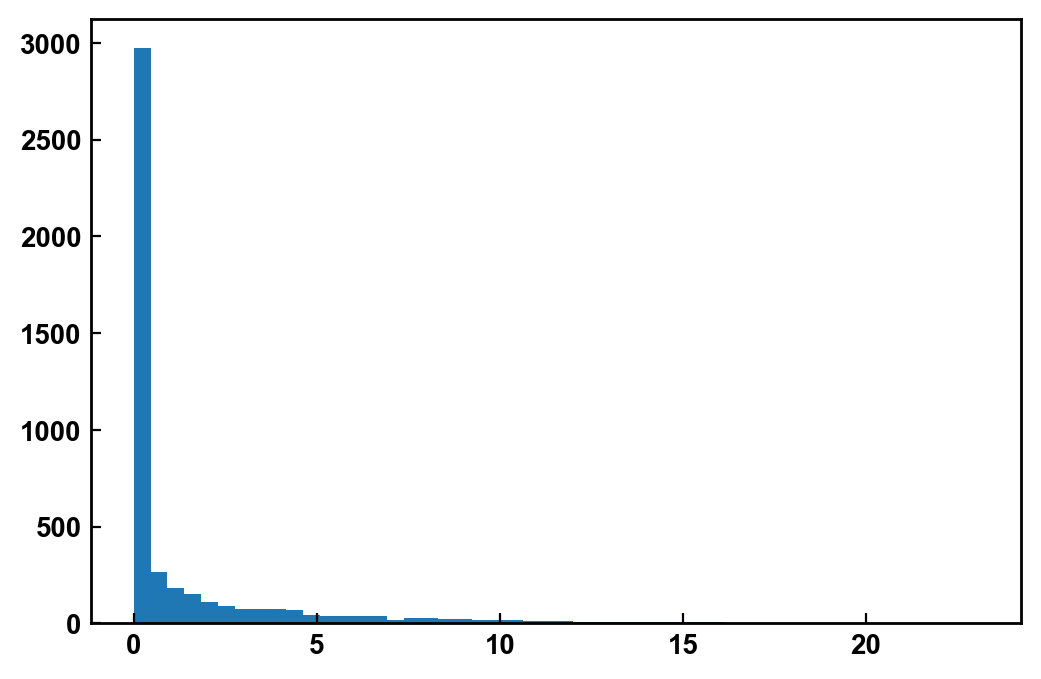

In [74]:
fig, ax = plt.subplots()
ax.hist(x / 3600, bins=50)
plt.show();

In [ ]:
fig, ax = plt.subplots()
ax.hist(df[df['is_attributed'] == 1].groupby(['ip', 'device']).count().reset_index()['ip'], bins=20)
plt.show();

In [ ]:
df['day'] = df['click_time'].dt.day
df['hour'] = df['click_time'].dt.hour

In [ ]:
df_temp = df.groupby(['ip', 'day', 'hour']).count()['app']
df_temp = df_temp.reset_index().rename(columns={'app' : 'ipxdayxhour_count'})
df_temp

In [ ]:
df_temp['ipxdayxhour_count'].describe()

In [ ]:
df_more = df.merge(df_temp, how='outer', on=['ip', 'hour'])
df_more['ipxdayxhour_count'].describe()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
ax.scatter(df_more['ipxdayxhour_count'], df_more['is_attributed'])
plt.show();